# Industrial AutoML Approach
Using python to orchestrate creation of AutoML for prediction. A custom model is made and deployed to endpoint for predictions and explanation. Prediction provides insight from the input, explain does the same with focus on contributing features more.

## Setting Up

In [1]:
from google.cloud import aiplatform
from datetime import datetime

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

In [33]:
REGION = 'us-central1'
PROJECT_ID='mlopstqc'
DATANAME = 'leaktest'
IDENTIFIER = '2'

# Resources
DEPLOY_COMPUTE = 'n1-standard-2'

# Model Training
VAR_TARGET = 'TestPressureMbar'
VAR_OMIT = 'transaction_id' 

In [3]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

In [6]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DIR = f"temp/{IDENTIFIER}"

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

## Creating Dataset

Linking to Data Source 

In [9]:
dataset = aiplatform.TabularDataset.create(
    display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'identifier':f'{IDENTIFIER}'}
)

INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/969346734638/locations/us-central1/datasets/4588899739453358080/operations/5068944935592394752
INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/969346734638/locations/us-central1/datasets/4588899739453358080
INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/969346734638/locations/us-central1/datasets/4588899739453358080')


## Training the Model with AutoML

In [10]:
column_specs = list(set(dataset.column_names) - set(VAR_OMIT.split()) - set([VAR_TARGET, 'splits']))


In [11]:
column_specs = dict.fromkeys(column_specs, 'auto')

In [14]:
tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    optimization_prediction_type = 'classification',
    optimization_objective = 'minimize-log-loss',
    column_specs = column_specs,
    labels = {'identifier':f'{IDENTIFIER}'}
)

In [25]:
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'splits',
    #    training_fraction_split = 0.8,
    #    validation_fraction_split = 0.1,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 500,
    # model_display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',  //Model already trained so load that up
    model_display_name = f'2_leaktest_20220323114941',
    disable_early_stopping = False,
    model_labels = {'identifier':f'{IDENTIFIER}'}
)

RuntimeError: AutoML Tabular Training has already run.

## Evaluate the Model

Setting up a model client for the model

In [1]:
model.resource_name

NameError: name 'model' is not defined

In [24]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [26]:
evaluations = model_client.list_model_evaluations(parent = model.resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)

In [27]:
geteval.metrics['auPrc']

0.76017636

In [28]:

for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])


True Label =  15500  has Predicted labels =  [2792.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [29]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [30]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  15000 has auPrc =  0.0023923444
Label =  41800 has auPrc =  0.00029904305
Label =  10400 has auPrc =  0.0029904307


KeyError: 'auPrc'

## Creating and Deploying Endpoint

In [31]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    labels = {'identifier':f'{IDENTIFIER}'}
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/969346734638/locations/us-central1/endpoints/7595786964490518528/operations/3095805348850696192
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/969346734638/locations/us-central1/endpoints/7595786964490518528
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/969346734638/locations/us-central1/endpoints/7595786964490518528')


In [34]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

INFO:google.cloud.aiplatform.models:Deploying Model projects/969346734638/locations/us-central1/models/5790806686100881408 to Endpoint : projects/969346734638/locations/us-central1/endpoints/7595786964490518528
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/969346734638/locations/us-central1/endpoints/7595786964490518528/operations/3275949333945516032
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/969346734638/locations/us-central1/endpoints/7595786964490518528


## Preparing Prediction record

In [35]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()


In [36]:
pred.head(4)

,TestVolumeLitre,AlarmDiffPressure,TestPressureMbar,transaction_id,splits
0,0.2,500,12800,68cfe17b-33f6-4240-9254-d77514feb083,TEST
1,10.0,320,12800,e6cc26be-a050-4c91-99cf-52c2dcea0924,TEST
2,0.1,320,12800,b5e82b71-f62a-400a-9cf1-f551b2b57bf9,TEST
3,0.1,320,12800,d2f9cc2b-4aed-4734-a723-17b44020021b,TEST


In [37]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]


In [43]:
newob['AlarmDiffPressure'] = str(newob['AlarmDiffPressure'])

In [44]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

In [45]:
instances

[struct_value {
   fields {
     key: "AlarmDiffPressure"
     value {
       string_value: "500"
     }
   }
   fields {
     key: "TestVolumeLitre"
     value {
       number_value: 0.2
     }
   }
 }]

In [46]:
parameters

struct_value {
}

## Getting Prediction

In [47]:
prediction = endpoint.predict(instances=instances, parameters=parameters)


In [48]:
prediction

Prediction(predictions=[{'classes': ['15500', '19800', '16400', '18000', '13600', '13400', '13200', '24000', '23600', '20800', '18200', '17800', '17600', '17200', '16800', '16000', '12800', '12000', '10200', '24400', '21200', '21000', '20600', '20000', '18800', '15000', '14200', '11200', '11000', '23400', '22200', '16600', '15800', '15600', '14800', '13000', '12600', '10800', '29800', '27200', '22800', '22600', '22400', '22000', '21800', '21400', '19200', '18400', '17000', '15400', '14400', '12200', '11400', '10600', '28800', '25200', '21600', '20200', '19600', '19000', '18600', '26600', '26200', '25000', '20400', '19400', '17400', '15200', '14000', '11800', '10000', '29400', '28000', '27800', '25800', '24600', '23200', '23000', '12400', '10400', '28400', '27000', '26800', '14600', '13800', '29200', '25400', '23800', '29000', '27400', '26000', '11600', '24800', '24200', '29600', '28200', '27600', '25600', '28600', '16200', '26400', '30400', '30200', '30000', '30600', '31600', '31800', 

In [49]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]


'15500'

## REST Prediction

In [50]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [51]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

E0323 16:16:31.342971018   28818 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{
  "predictions": [
    {
      "classes": [
        "15500",
        "19800",
        "16400",
        "18000",
        "13600",
        "13400",
        "13200",
        "24000",
        "23600",
        "20800",
        "18200",
        "17800",
        "17600",
        "17200",
        "16800",
        "16000",
        "12800",
        "12000",
        "10200",
        "24400",
        "21200",
        "21000",
        "20600",
        "20000",
        "18800",
        "15000",
        "14200",
        "11200",
        "11000",
        "23400",
        "22200",
        "16600",
        "15800",
        "15600",
        "14800",
        "13000",
        "12600",
        "10800",
        "29800",
        "27200",
        "22800",
        "22600",
        "22400",
        "22000",
        "21800",
        "21400",
        "19200",
        "18400",
        "17000",
        "15400",
        "14400",
        "12200",
        "11400",
        "10600",
        "28800",
        "25200",
  

## Terminal

In [52]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json


E0323 16:17:01.335273118   28818 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['15500', '19800', '16400', '18000', '13600', '13400', '13200', '24000', '23600', '20800', '18200', '17800', '17600', '17200', '16800', '16000', '12800', '12000', '10200', '24400', '21200', '21000', '20600', '20000', '18800', '15000', '14200', '11200', '11000', '23400', '22200', '16600', '15800', '15600', '14800', '13000', '12600', '10800', '29800', '27200', '22800', '22600', '22400', '22000', '21800', '21400', '19200', '18400', '17000', '15400', '14400', '12200', '11400', '10600', '28800', '25200', '21600', '20200', '19600', '19000', '18600', '26600', '26200', '25000', '20400', '19400', '17400', '15200', '14000', '11800', '10000', '29400', '28000', '27800', '25800', '24600', '23200', '23000', '12400', '10400', '28400', '27000', '26800', '14600', '13800', '29200', '25400', '23800', '29000', '27400', '26000', '11600', '24800', '24200', '29600', '28200', '27600', '25600', '28600', '16200', '26400', '3

## Interpretation

In [53]:
explanation = endpoint.explain(instances=instances, parameters=parameters)


In [54]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.7332785129547119
instance output 0.8985325694084167
output_index [0]
output display value 15500
approximation error 0.005494354099395934


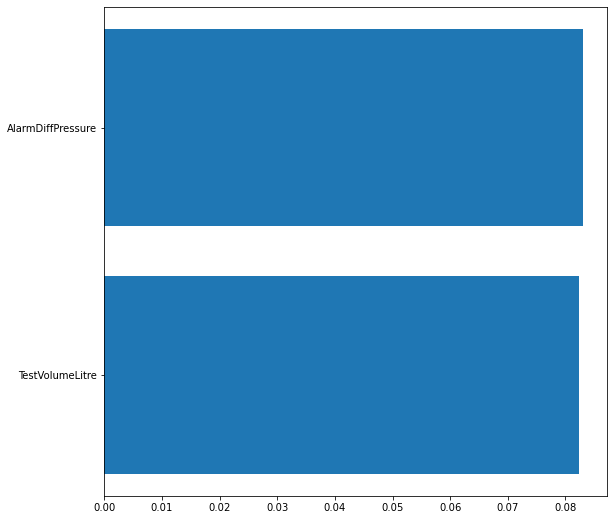

In [55]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

## Batch Prediction

End-to-End

In [56]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{IDENTIFIER}_{DATANAME}_{TIMESTAMP}',
    model_name = model.name,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation = True,
    labels = {'identifier':f'{IDENTIFIER}'}
)

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/969346734638/locations/us-central1/batchPredictionJobs/4435509621041397760
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/969346734638/locations/us-central1/batchPredictionJobs/4435509621041397760')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/4435509621041397760?project=969346734638
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/969346734638/locations/us-central1/batchPredictionJobs/4435509621041397760 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/969346734638/locations/us-central1/batchPredictionJobs/4435509621041397760 current state:
JobState.JOB_STAT